In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [3]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [7]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [8]:
file_import = drive.CreateFile({'id':'15j1Nou6m5WNLejJQrUcty6U03xsIgIAI'})
file_import.GetContentFile('SelfAttention.py') 

from SelfAttention import SelfAttention

In [9]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [10]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [11]:
def single_category_regressor(features, unitsNumber = 64):
    dense_1 = Dense(unitsNumber, activation = 'elu')(features)
    dense_1_normalization = BatchNormalization()(dense_1)
    dense_1_dropout = Dropout(0.2)(dense_1_normalization)

    dense_2 = Dense(unitsNumber, activation = 'elu')(dense_1_dropout)
    dense_2_normalization = BatchNormalization()(dense_2)
    dense_2_dropout = Dropout(0.2)(dense_2_normalization)
    
    return Dense(1, activation='elu')(dense_2_dropout)

In [12]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

embedding_dropout = SelfAttention()(embedding_dropout)

features_1 = one_by_one(filtersNumber, embedding_dropout)
features_2 = one_by_one(filtersNumber, features_1)
features_3 = one_by_one(filtersNumber, features_2)

features = yoon_kim_feature_extractor(filtersNumber, features_3)


dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

single_category_layer = concatenate([
    single_category_regressor(features, 64),
    single_category_regressor(features, 64),
    single_category_regressor(features, 64),
    single_category_regressor(features, 64),
    single_category_regressor(features, 64),
    single_category_regressor(features, 64),
])

output_layer = multiply([output_layer, single_category_layer])

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21376/102124 [=====>........................] - ETA: 7:59 - loss: 0.4192 - acc: 0.6075

102112/102124 [============================>.] - ETA: 0s - loss: 0.2607 - acc: 0.5961

102124/102124 [==============================] - 621s 6ms/step - loss: 0.2606 - acc: 0.5961 - val_loss: 5.5689 - val_acc: 0.3888
Epoch 2/32
 10144/102124 [=>............................] - ETA: 8:40 - loss: 0.1775 - acc: 0.5940

102112/102124 [============================>.] - ETA: 0s - loss: 0.1668 - acc: 0.6390

102124/102124 [==============================] - 617s 6ms/step - loss: 0.1668 - acc: 0.6390 - val_loss: 0.1091 - val_acc: 0.6408
roc-auc: 0.782 - roc-auc_val: 0.7806                                                                                                    
Epoch 3/32
  8768/102124 [=>............................] - ETA: 8:48 - loss: 0.1285 - acc: 0.6760

 89344/102124 [=========================>....] - ETA: 1:12 - loss: 0.1502 - acc: 0.6658

102124/102124 [==============================] - 623s 6ms/step - loss: 0.1491 - acc: 0.6708 - val_loss: 0.0826 - val_acc: 0.7143
Epoch 4/32
  9216/102124 [=>............................] - ETA: 8:48 - loss: 0.1310 - acc: 0.7215

 71904/102124 [====================>.........] - ETA: 2:52 - loss: 0.1284 - acc: 0.7622

102124/102124 [==============================] - 625s 6ms/step - loss: 0.1270 - acc: 0.7676 - val_loss: 0.1221 - val_acc: 0.8392
roc-auc: 0.8695 - roc-auc_val: 0.8721                                                                                                    
Epoch 5/32
  1568/102124 [..............................] - ETA: 9:24 - loss: 0.1106 - acc: 0.7879

102112/102124 [============================>.] - ETA: 0s - loss: 0.1101 - acc: 0.8342

102124/102124 [==============================] - 624s 6ms/step - loss: 0.1101 - acc: 0.8342 - val_loss: 0.0702 - val_acc: 0.8488
Epoch 6/32
 14048/102124 [===>..........................] - ETA: 8:22 - loss: 0.1034 - acc: 0.8575

 65600/102124 [==================>...........] - ETA: 3:30 - loss: 0.1001 - acc: 0.8560

102124/102124 [==============================] - 626s 6ms/step - loss: 0.0992 - acc: 0.8594 - val_loss: 0.1062 - val_acc: 0.8514
roc-auc: 0.8756 - roc-auc_val: 0.8766                                                                                                    
Epoch 7/32
    32/102124 [..............................] - ETA: 10:04 - loss: 0.0541 - acc: 0.8750

102112/102124 [============================>.] - ETA: 0s - loss: 0.0966 - acc: 0.8973

102124/102124 [==============================] - 626s 6ms/step - loss: 0.0966 - acc: 0.8974 - val_loss: 0.0658 - val_acc: 0.9621
Epoch 8/32
 14048/102124 [===>..........................] - ETA: 8:22 - loss: 0.0871 - acc: 0.9511

 76928/102124 [=====================>........] - ETA: 2:23 - loss: 0.0897 - acc: 0.9534

102124/102124 [==============================] - 624s 6ms/step - loss: 0.0890 - acc: 0.9553 - val_loss: 0.0698 - val_acc: 0.9595
roc-auc: 0.9594 - roc-auc_val: 0.9561                                                                                                    
Epoch 9/32
  2752/102124 [..............................] - ETA: 9:27 - loss: 0.0955 - acc: 0.9496

102112/102124 [============================>.] - ETA: 0s - loss: 0.0884 - acc: 0.9650

102124/102124 [==============================] - 622s 6ms/step - loss: 0.0884 - acc: 0.9650 - val_loss: 0.0722 - val_acc: 0.9713

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00021763764380011708.
Epoch 10/32
  8032/102124 [=>............................] - ETA: 8:56 - loss: 0.0836 - acc: 0.9657

 68512/102124 [===================>..........] - ETA: 3:13 - loss: 0.0832 - acc: 0.9688

102124/102124 [==============================] - 626s 6ms/step - loss: 0.0827 - acc: 0.9693 - val_loss: 0.0600 - val_acc: 0.9756
roc-auc: 0.9653 - roc-auc_val: 0.9656                                                                                                    
Epoch 11/32
   768/102124 [..............................] - ETA: 9:32 - loss: 0.0712 - acc: 0.9701

 79232/102124 [======================>.......] - ETA: 2:08 - loss: 0.0827 - acc: 0.9692

102124/102124 [==============================] - 615s 6ms/step - loss: 0.0813 - acc: 0.9700 - val_loss: 0.0584 - val_acc: 0.9769
Epoch 12/32
  5312/102124 [>.............................] - ETA: 9:12 - loss: 0.0785 - acc: 0.9716

102112/102124 [============================>.] - ETA: 0s - loss: 0.0839 - acc: 0.9695

102124/102124 [==============================] - 616s 6ms/step - loss: 0.0839 - acc: 0.9695 - val_loss: 0.0580 - val_acc: 0.9777
roc-auc: 0.9671 - roc-auc_val: 0.9643                                                                                                    
Epoch 13/32
  8704/102124 [=>............................] - ETA: 8:43 - loss: 0.0835 - acc: 0.9706

 76224/102124 [=====================>........] - ETA: 2:27 - loss: 0.0791 - acc: 0.9720

102124/102124 [==============================] - 617s 6ms/step - loss: 0.0777 - acc: 0.9723 - val_loss: 0.0590 - val_acc: 0.9760
Epoch 14/32
  4160/102124 [>.............................] - ETA: 9:10 - loss: 0.0724 - acc: 0.9733

102112/102124 [============================>.] - ETA: 0s - loss: 0.0773 - acc: 0.9723

102124/102124 [==============================] - 611s 6ms/step - loss: 0.0773 - acc: 0.9723 - val_loss: 0.0588 - val_acc: 0.9761
roc-auc: 0.9709 - roc-auc_val: 0.968                                                                                                    
Epoch 15/32
  8736/102124 [=>............................] - ETA: 8:53 - loss: 0.0760 - acc: 0.9708

102112/102124 [============================>.] - ETA: 0s - loss: 0.0734 - acc: 0.9728

102124/102124 [==============================] - 616s 6ms/step - loss: 0.0734 - acc: 0.9728 - val_loss: 0.0564 - val_acc: 0.9766
Epoch 16/32
 13984/102124 [===>..........................] - ETA: 8:14 - loss: 0.0684 - acc: 0.9750

102112/102124 [============================>.] - ETA: 0s - loss: 0.0731 - acc: 0.9734

102124/102124 [==============================] - 616s 6ms/step - loss: 0.0731 - acc: 0.9734 - val_loss: 0.0546 - val_acc: 0.9771
roc-auc: 0.9718 - roc-auc_val: 0.9681                                                                                                    
Epoch 17/32
  8704/102124 [=>............................] - ETA: 8:43 - loss: 0.0672 - acc: 0.9747

102112/102124 [============================>.] - ETA: 0s - loss: 0.0701 - acc: 0.9736

102124/102124 [==============================] - 615s 6ms/step - loss: 0.0701 - acc: 0.9736 - val_loss: 0.0549 - val_acc: 0.9775
Epoch 18/32
 13856/102124 [===>..........................] - ETA: 8:39 - loss: 0.0697 - acc: 0.9743

 63680/102124 [=================>............] - ETA: 3:45 - loss: 0.0702 - acc: 0.9734

102112/102124 [============================>.] - ETA: 0s - loss: 0.0695 - acc: 0.9738

102124/102124 [==============================] - 636s 6ms/step - loss: 0.0695 - acc: 0.9738 - val_loss: 0.0542 - val_acc: 0.9779
roc-auc: 0.9695 - roc-auc_val: 0.966                                                                                                    
Epoch 19/32
  8736/102124 [=>............................] - ETA: 8:45 - loss: 0.0655 - acc: 0.9753

 45952/102124 [============>.................] - ETA: 5:22 - loss: 0.0676 - acc: 0.9745

102112/102124 [============================>.] - ETA: 0s - loss: 0.0681 - acc: 0.9736

102124/102124 [==============================] - 635s 6ms/step - loss: 0.0681 - acc: 0.9736 - val_loss: 0.0644 - val_acc: 0.9705
Epoch 20/32
 13888/102124 [===>..........................] - ETA: 8:39 - loss: 0.0675 - acc: 0.9739

 56640/102124 [===============>..............] - ETA: 4:28 - loss: 0.0673 - acc: 0.9747

 96288/102124 [===========================>..] - ETA: 34s - loss: 0.0672 - acc: 0.9745

102124/102124 [==============================] - 642s 6ms/step - loss: 0.0671 - acc: 0.9746 - val_loss: 0.0551 - val_acc: 0.9772

Epoch 00020: ReduceLROnPlateau reducing learning rate to 6.934809061931446e-05.
roc-auc: 0.9706 - roc-auc_val: 0.9682                                                                                                    
Epoch 21/32
  5984/102124 [>.............................] - ETA: 9:25 - loss: 0.0644 - acc: 0.9760

 59168/102124 [================>.............] - ETA: 4:13 - loss: 0.0666 - acc: 0.9748

102112/102124 [============================>.] - ETA: 0s - loss: 0.0666 - acc: 0.9746

102124/102124 [==============================] - 641s 6ms/step - loss: 0.0666 - acc: 0.9746 - val_loss: 0.0545 - val_acc: 0.9782
Epoch 22/32
 13984/102124 [===>..........................] - ETA: 8:32 - loss: 0.0695 - acc: 0.9749

 53472/102124 [==============>...............] - ETA: 4:44 - loss: 0.0663 - acc: 0.9750

 97440/102124 [===========================>..] - ETA: 27s - loss: 0.0666 - acc: 0.9746

102124/102124 [==============================] - 639s 6ms/step - loss: 0.0665 - acc: 0.9746 - val_loss: 0.0576 - val_acc: 0.9757
roc-auc: 0.973 - roc-auc_val: 0.9703                                                                                                    
Epoch 23/32
  7616/102124 [=>............................] - ETA: 9:06 - loss: 0.0640 - acc: 0.9745

102112/102124 [============================>.] - ETA: 0s - loss: 0.0648 - acc: 0.9745

102124/102124 [==============================] - 634s 6ms/step - loss: 0.0647 - acc: 0.9745 - val_loss: 0.0535 - val_acc: 0.9775
Epoch 24/32
 13984/102124 [===>..........................] - ETA: 8:31 - loss: 0.0674 - acc: 0.9756

102112/102124 [============================>.] - ETA: 0s - loss: 0.0648 - acc: 0.9754

102124/102124 [==============================] - 632s 6ms/step - loss: 0.0648 - acc: 0.9754 - val_loss: 0.0529 - val_acc: 0.9795
roc-auc: 0.9729 - roc-auc_val: 0.9705                                                                                                    
Epoch 25/32
  8704/102124 [=>............................] - ETA: 9:01 - loss: 0.0640 - acc: 0.9759

 63072/102124 [=================>............] - ETA: 3:49 - loss: 0.0641 - acc: 0.9754

102112/102124 [============================>.] - ETA: 0s - loss: 0.0636 - acc: 0.9756

102124/102124 [==============================] - 640s 6ms/step - loss: 0.0636 - acc: 0.9756 - val_loss: 0.0519 - val_acc: 0.9794
Epoch 26/32
 13824/102124 [===>..........................] - ETA: 8:41 - loss: 0.0633 - acc: 0.9759

 76896/102124 [=====================>........] - ETA: 2:29 - loss: 0.0636 - acc: 0.9755

102124/102124 [==============================] - 647s 6ms/step - loss: 0.0633 - acc: 0.9754 - val_loss: 0.0513 - val_acc: 0.9783
roc-auc: 0.9722 - roc-auc_val: 0.9714                                                                                                    
Epoch 27/32
  2720/102124 [..............................] - ETA: 9:47 - loss: 0.0718 - acc: 0.9748

 50944/102124 [=============>................] - ETA: 5:02 - loss: 0.0609 - acc: 0.9764

 89312/102124 [=========================>....] - ETA: 1:16 - loss: 0.0621 - acc: 0.9762

102124/102124 [==============================] - 648s 6ms/step - loss: 0.0620 - acc: 0.9762 - val_loss: 0.0542 - val_acc: 0.9794
Epoch 28/32
  8960/102124 [=>............................] - ETA: 9:04 - loss: 0.0620 - acc: 0.9766

 48000/102124 [=============>................] - ETA: 5:17 - loss: 0.0624 - acc: 0.9760

 84736/102124 [=======================>......] - ETA: 1:42 - loss: 0.0624 - acc: 0.9760

102124/102124 [==============================] - 640s 6ms/step - loss: 0.0626 - acc: 0.9759 - val_loss: 0.0529 - val_acc: 0.9777
roc-auc: 0.9741 - roc-auc_val: 0.9719                                                                                                    
Epoch 29/32
  4576/102124 [>.............................] - ETA: 9:38 - loss: 0.0574 - acc: 0.9774

 63104/102124 [=================>............] - ETA: 3:52 - loss: 0.0633 - acc: 0.9758

102112/102124 [============================>.] - ETA: 0s - loss: 0.0626 - acc: 0.9762

102124/102124 [==============================] - 647s 6ms/step - loss: 0.0626 - acc: 0.9762 - val_loss: 0.0511 - val_acc: 0.9793
Epoch 30/32
 13984/102124 [===>..........................] - ETA: 8:41 - loss: 0.0637 - acc: 0.9757

 60192/102124 [================>.............] - ETA: 4:09 - loss: 0.0626 - acc: 0.9762

 98336/102124 [===========================>..] - ETA: 22s - loss: 0.0627 - acc: 0.9762

102124/102124 [==============================] - 649s 6ms/step - loss: 0.0626 - acc: 0.9762 - val_loss: 0.0519 - val_acc: 0.9791
roc-auc: 0.9739 - roc-auc_val: 0.9719                                                                                                    
Epoch 31/32
  7808/102124 [=>............................] - ETA: 9:12 - loss: 0.0626 - acc: 0.9754

 55456/102124 [===============>..............] - ETA: 4:35 - loss: 0.0621 - acc: 0.9767

 92096/102124 [==========================>...] - ETA: 59s - loss: 0.0617 - acc: 0.9766

102124/102124 [==============================] - 643s 6ms/step - loss: 0.0617 - acc: 0.9766 - val_loss: 0.0511 - val_acc: 0.9798

Epoch 00031: ReduceLROnPlateau reducing learning rate to 2.209708691225387e-05.
Epoch 32/32
  7392/102124 [=>............................] - ETA: 9:22 - loss: 0.0648 - acc: 0.9769

 54976/102124 [===============>..............] - ETA: 4:39 - loss: 0.0620 - acc: 0.9767

 91552/102124 [=========================>....] - ETA: 1:02 - loss: 0.0623 - acc: 0.9765

102124/102124 [==============================] - 644s 6ms/step - loss: 0.0625 - acc: 0.9764 - val_loss: 0.0510 - val_acc: 0.9795
roc-auc: 0.9754 - roc-auc_val: 0.9729                                                                                                    


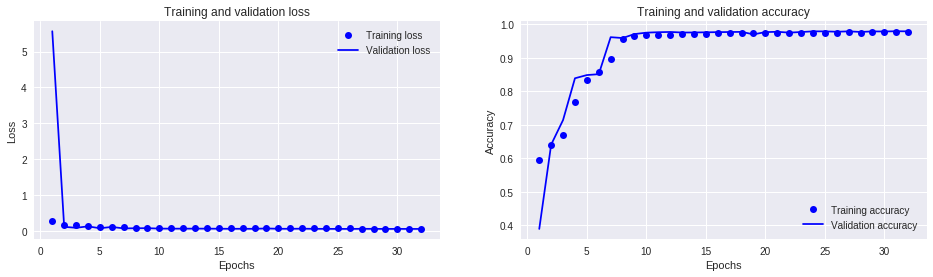

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 54s 2ms/step
([0.05013177567211957, 0.9804689437771934], 0.975156371078949)
